In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
import pandas as pd

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:00


In [4]:

from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np
from scipy.spatial.distance import cosine
from collections import defaultdict
from torch import PyTorchFileReader
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [7]:
from sklearn.model_selection import train_test_split
from scipy.special import softmax
data = pd.read_csv("/content/pre_processed_final.csv")
print(data.shape)
data = data[["sentiment", "text"]]
data = data.dropna()
data.head()
train_X, valid_X, train_y, valid_y = train_test_split(data['text'], data['sentiment'], test_size = 0.2, random_state=42)  

(28777, 3)


Streaming output truncated to the last 5000 lines.
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
9

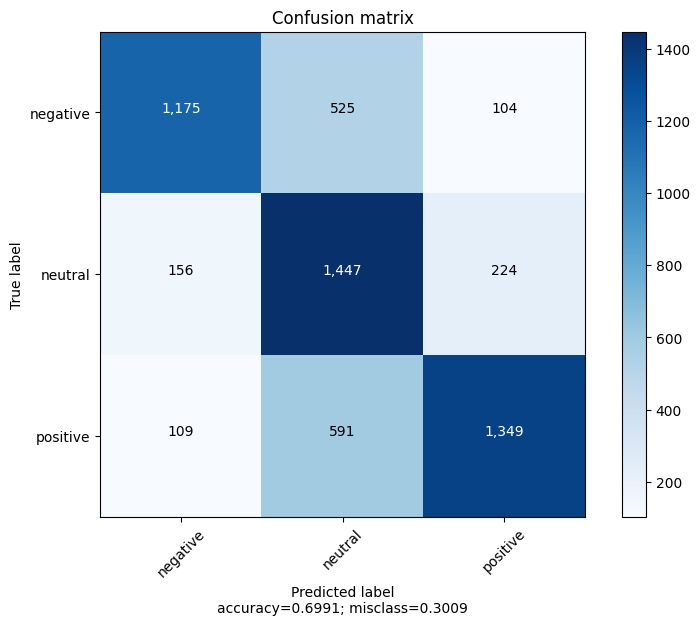

In [8]:
from transformers import pipeline

# load the sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
import pickle
with open("roberta.pkl", "wb") as f:
    pickle.dump(classifier, f)

map_ = {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}
predictions = []
for i, line in enumerate(valid_X):
  # print(i)
  result = classifier(line)
  predictions.append(result[0]["label"])

original = []
for each in predictions:
  original.append(map_[each])

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def plot_confusion(pred_label, y_test, labels = ["negative", "neutral", "positive"]):
    conf_mat = confusion_matrix(y_test, pred_label)
    plot_confusion_matrix(conf_mat, labels)

def get_correct_label_count(pred_label, original_label):
    return np.sum(np.array(pred_label) == np.array(original_label))

from sklearn.metrics import recall_score, f1_score
labels=[-1, 0, 1]
def get_recall_scores(pred_label, original_label):
    return recall_score(original_label, pred_label,labels=labels, average=None)


def get_f1_scores(pred_label, original_label):
    return f1_score(original_label, pred_label,labels=labels, average=None)

def measure_and_print_metrics(pred_label, original_label):
    print("-1: negative, 0: Neutral, 1:Positive\n")
    print(f"Accuracy:")
    print(f"correct-count:{get_correct_label_count(pred_label, original_label)},"
          f"correct_percentage: {get_correct_label_count(pred_label, original_label) / len(pred_label):.2f}% "
          f"count: {len(pred_label)}")
    print("============================================")
    print("Recall values:")
    recall_score = get_recall_scores(pred_label,original_label)
    print(recall_score)
    print(f"Recall score: {np.sum(recall_score)/3.0:.2f}")
    print("============================================")
    print("F1- scores:")
    f1_scores = get_f1_scores(pred_label, original_label)
    print(f1_scores)
    print(f"F1_measure metric: {np.sum(f1_scores)/2.0:.2f}")
    print("=============================================")
    plot_confusion(pred_label, original_label)
  
measure_and_print_metrics(original, valid_y)